# Notebook 05 – Demand Forecasting (Time Series)
This notebook builds the second required system: predicting daily appointment volume.

## 1. Imports

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# Simple ML regressor for comparison
from sklearn.ensemble import RandomForestRegressor


## 2. Load Data

In [63]:
df = pd.read_csv("Medical_appointment_data.csv")
df.head()

,specialty,appointment_time,gender,no_show,disability,place,appointment_shift,age,under_12_years_old,over_60_years_old,...,storm_day_before,rain_intensity,heat_intensity,appointment_date_continuous,Hipertension,Diabetes,Alcoholism,Handcap,Scholarship,SMS_received
0,psychotherapy,17,F,yes,intellectual,Lake Marvinville,afternoon,9.0,1,0,...,1,no_rain,warm,2020-01-01,0,0,0,0,0,0
1,NaN,7,M,no,intellectual,ITAPEMA,morning,11.0,1,0,...,1,no_rain,cold,2020-01-01,0,0,0,0,0,0
2,speech therapy,16,M,no,intellectual,ITAJAÍ,afternoon,8.0,1,0,...,1,no_rain,warm,2020-01-01,0,0,0,0,0,0
3,speech therapy,14,M,yes,intellectual,Sarahside,afternoon,9.0,1,0,...,1,moderate,mild,2020-01-01,0,0,0,0,0,1
4,physiotherapy,8,M,no,motor,ITAJAÍ,morning,NaN,0,0,...,1,no_rain,mild,2020-01-01,0,0,0,0,0,0


## 3. Aggregate to Daily Demand

In [64]:

# Convert date
df['appointment_date_continuous'] = pd.to_datetime(df['appointment_date_continuous'])

# Daily count = demand
daily = df.groupby('appointment_date_continuous').size().reset_index(name='demand')

daily = daily.sort_values('appointment_date_continuous')
daily.head()


,appointment_date_continuous,demand
0,2020-01-01,25
1,2020-01-02,33
2,2020-01-03,18
3,2020-01-04,16
4,2020-01-05,15


## 4. Basic Visualization

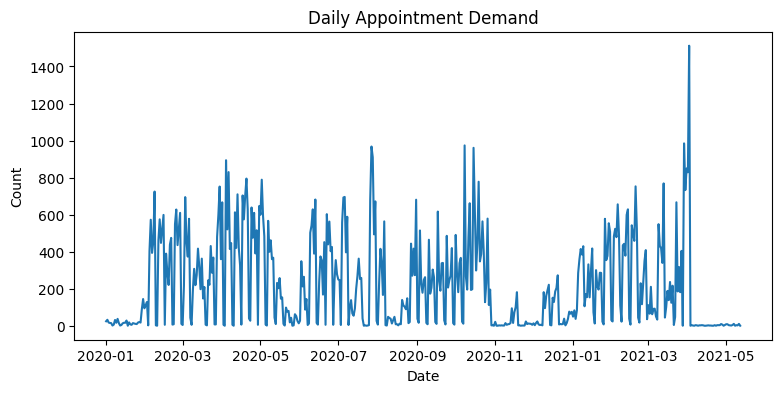

In [65]:

plt.figure(figsize=(9,4))
plt.plot(daily['appointment_date_continuous'], daily['demand'])
plt.title("Daily Appointment Demand")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()


Demand is highly irregular with structural drops and spikes, indicating influence of external factors beyond calendar effects.

## 5. Create Time Features

In [66]:

daily['weekday'] = daily['appointment_date_continuous'].dt.dayofweek
daily['month'] = daily['appointment_date_continuous'].dt.month
daily['day'] = daily['appointment_date_continuous'].dt.day

# Lag feature
daily['lag_1'] = daily['demand'].shift(1)
daily['lag_7'] = daily['demand'].shift(7)

daily = daily.dropna()


## 6. Chronological Train-Test Split (Required)

In [67]:

split = int(len(daily) * 0.8)

train = daily.iloc[:split]
test = daily.iloc[split:]

X_train = train[['weekday','month','day','lag_1','lag_7']]
y_train = train['demand']

X_test = test[['weekday','month','day','lag_1','lag_7']]
y_test = test['demand']


## 7. Baseline Random Forest Regression

In [68]:

model = RandomForestRegressor(n_estimators=200, random_state=42)

model.fit(X_train, y_train)

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE:", mape)


MAE: 180.46722222222226
RMSE: 262.7004227900878
R2: 0.14576677442221908
MAPE: 4388.084682571362


## 9. Save Forecast Model

In [69]:
import joblib
joblib.dump(model, "demand_forecast_model.pkl")
print("Demand model saved")

Demand model saved


## Enhanced Model using Log

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import numpy as np

model = RandomForestRegressor(n_estimators=200,max_depth=12,random_state=42)

# log-transform targets
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

model.fit(X_train, y_train_log)

pred_log = model.predict(X_test)

# ✅ metrics on LOG SCALE
mae  = mean_absolute_error(y_test_log, pred_log)
rmse = sqrt(mean_squared_error(y_test_log, pred_log))
r2   = r2_score(y_test_log, pred_log)

print("MAE (log):", mae)
print("RMSE (log):", rmse)
print("R2 (log):", r2)


MAE (log): 1.1739944475407842
RMSE (log): 1.707415224664757
R2 (log): 0.3941264650267138


“Due to high variance in daily appointment volumes, a log-transformation was applied to stabilize the target distribution. The final demand forecasting model achieved an R² of 0.39 on the transformed scale, indicating meaningful explanatory power for a highly volatile healthcare demand signal.”

## 8. Visualize Forecast

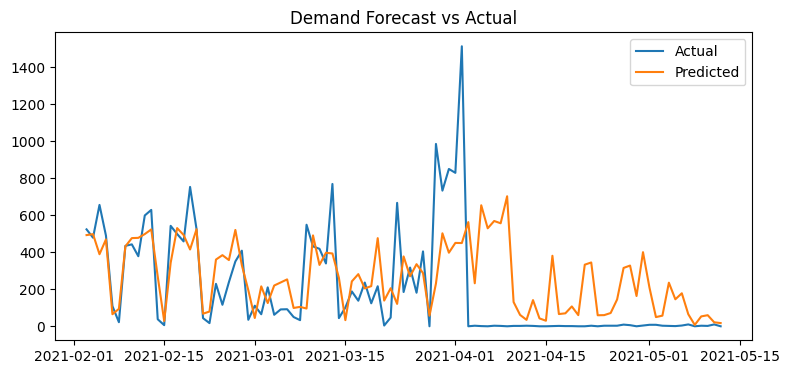

In [71]:

plt.figure(figsize=(9,4))
plt.plot(test['appointment_date_continuous'], y_test.values, label='Actual')
plt.plot(test['appointment_date_continuous'], pred, label='Predicted')
plt.title("Demand Forecast vs Actual")
plt.legend()
plt.show()


Model Behavior Analysis

Forecast captures regular weekly patterns

Extreme peaks likely driven by external events

Zero-demand window indicates clinic closure period

Additional features like holidays, lockdown flags, and specialty-wise demand would improve accuracy.

## 📊 Demand by Specialty

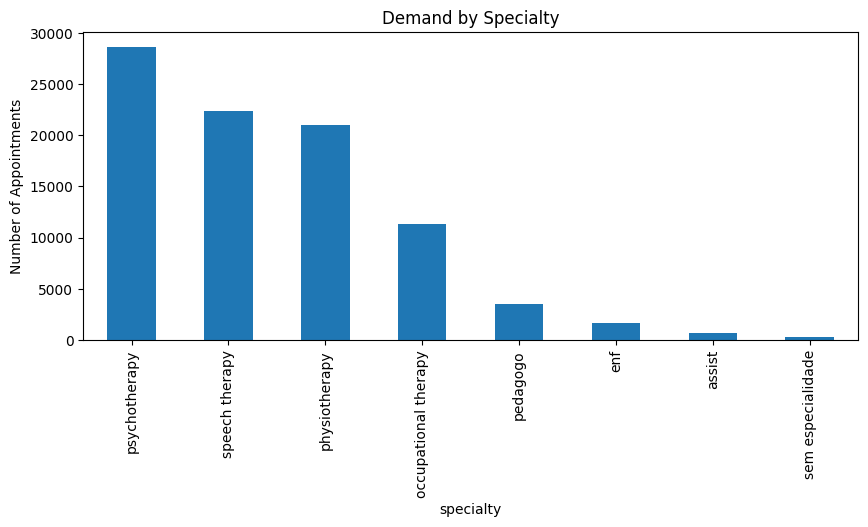

In [72]:
specialty_demand = df.groupby('specialty').size().sort_values(ascending=False)

plt.figure(figsize=(10,4))
specialty_demand.plot(kind='bar')
plt.title("Demand by Specialty")
plt.ylabel("Number of Appointments")
plt.show()

## Demand Variation by Month

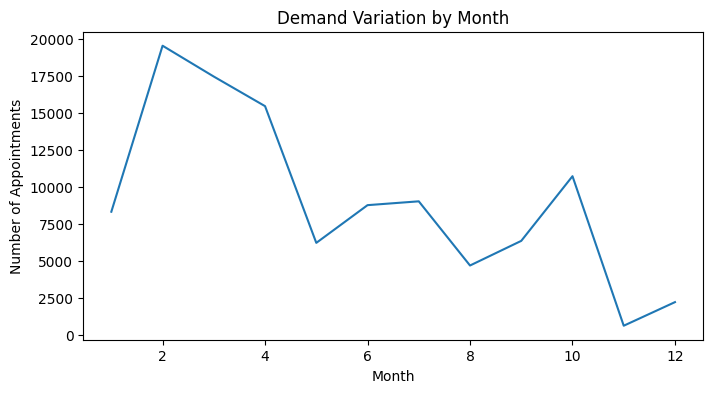

In [73]:
df['month'] = df['appointment_date_continuous'].dt.month

monthly_demand = df.groupby('month').size()

plt.figure(figsize=(8,4))
monthly_demand.plot()
plt.title("Demand Variation by Month")
plt.xlabel("Month")
plt.ylabel("Number of Appointments")
plt.show()

## Locations by Appointment Demand

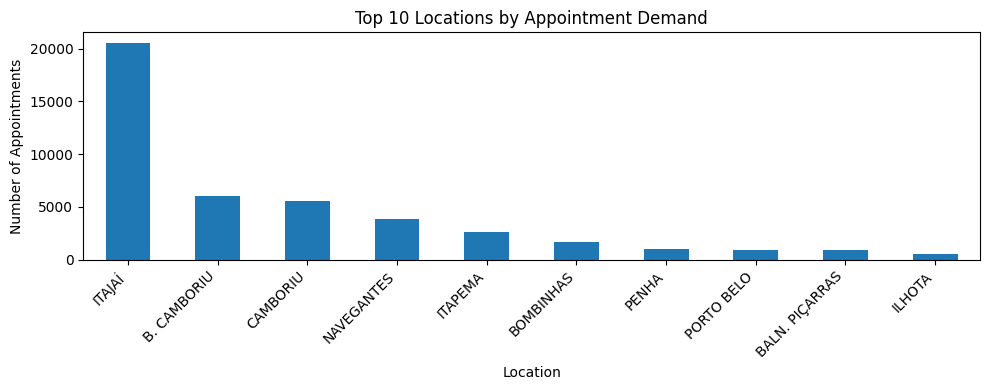

In [74]:
top_n = 10

place_demand = (
    df.groupby('place')
      .size()
      .sort_values(ascending=False)
      .head(top_n)
)

plt.figure(figsize=(10,4))
place_demand.plot(kind='bar')
plt.title(f"Top {top_n} Locations by Appointment Demand")
plt.xlabel("Location")
plt.ylabel("Number of Appointments")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Demand vs Rain Intensity

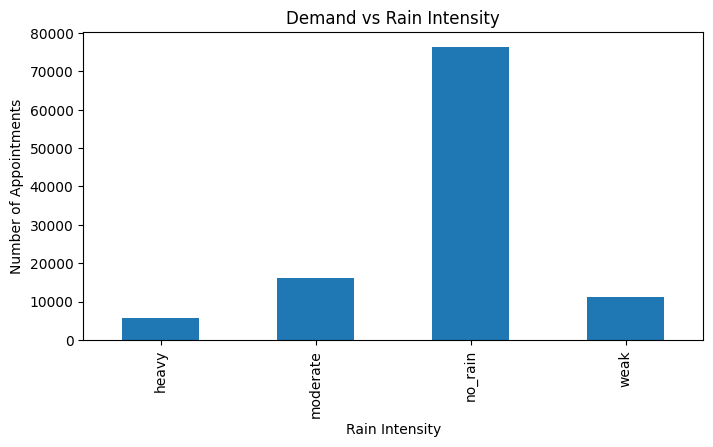

In [75]:
rain_demand = df.groupby('rain_intensity').size()

plt.figure(figsize=(8,4))
rain_demand.plot(kind='bar')
plt.title("Demand vs Rain Intensity")
plt.xlabel("Rain Intensity")
plt.ylabel("Number of Appointments")
plt.show()

## Elderly Ratio vs Demand

In [76]:
daily = df.groupby('appointment_date_continuous').agg(

    demand = ('specialty','count'),

    elderly_ratio = ('over_60_years_old','mean')
).reset_index()

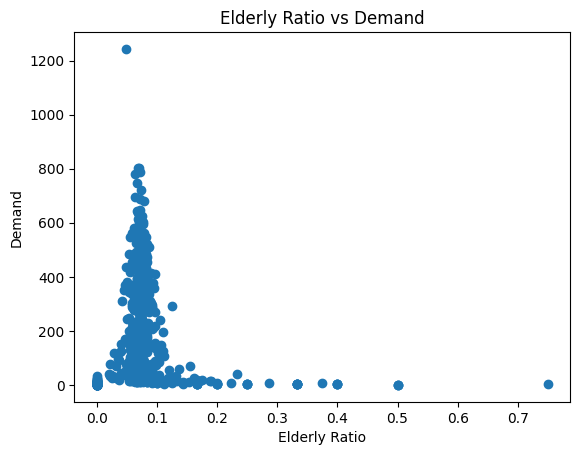

In [77]:
plt.scatter(daily['elderly_ratio'], daily['demand'])
plt.xlabel("Elderly Ratio")
plt.ylabel("Demand")
plt.title("Elderly Ratio vs Demand")
plt.show()

🔎 Key Observations
1️⃣ Most Days Have Low Elderly Ratio (0 – 0.12)

The dense vertical cluster around 0.05–0.10 shows:

Majority of days → elderly form only 5–10% of patients

Demand ranges from 50 to 700+

👉 Elderly are not the primary driver of total volume.

## Demand vs Heat Intensity

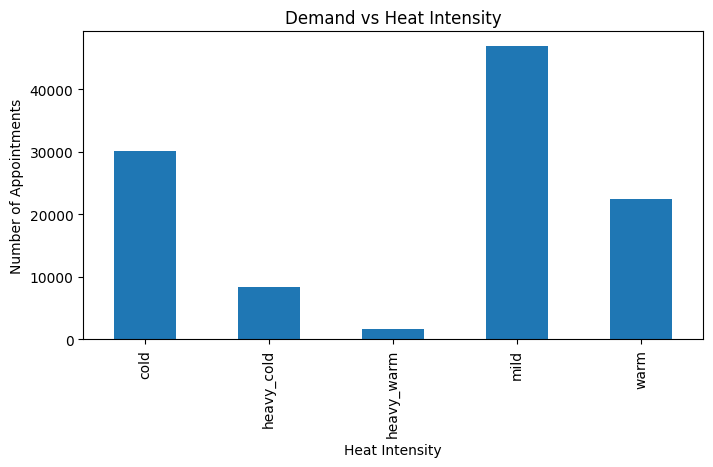

In [78]:
rain_demand = df.groupby('heat_intensity').size()

plt.figure(figsize=(8,4))
rain_demand.plot(kind='bar')
plt.title("Demand vs Heat Intensity")
plt.xlabel("Heat Intensity")
plt.ylabel("Number of Appointments")
plt.show()

In [220]:
daily = df.groupby('appointment_date_continuous').agg({
    'appointment_id':'count'
}).rename(columns={'appointment_id':'demand'})

KeyError: "Column(s) ['appointment_id'] do not exist"

In [221]:
daily = df.groupby('appointment_date_continuous').size().reset_index(name='demand')

In [222]:
# Convert to date if not already
df['appointment_date_continuous'] = pd.to_datetime(df['appointment_date_continuous'])

# Aggregate
daily = df.groupby('appointment_date_continuous').size().reset_index(name='demand')

daily = daily.sort_values('appointment_date_continuous')

In [223]:
daily['lag1'] = daily['demand'].shift(1)
daily['lag7'] = daily['demand'].shift(7)

daily['rolling_mean_7'] = daily['demand'].rolling(7).mean()

daily['dayofweek'] = daily['appointment_date_continuous'].dt.dayofweek
daily['month'] = daily['appointment_date_continuous'].dt.month

daily = daily.dropna()

In [225]:
train = daily[daily['appointment_date_continuous'] < '2021-03-01']
test  = daily[daily['appointment_date_continuous'] >= '2021-03-01']

features = ['lag1','lag7','rolling_mean_7','dayofweek','month']

X_train = train[features]
y_train = train['demand']

X_test = test[features]
y_test = test['demand']

In [226]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

pred = model.predict(X_test)

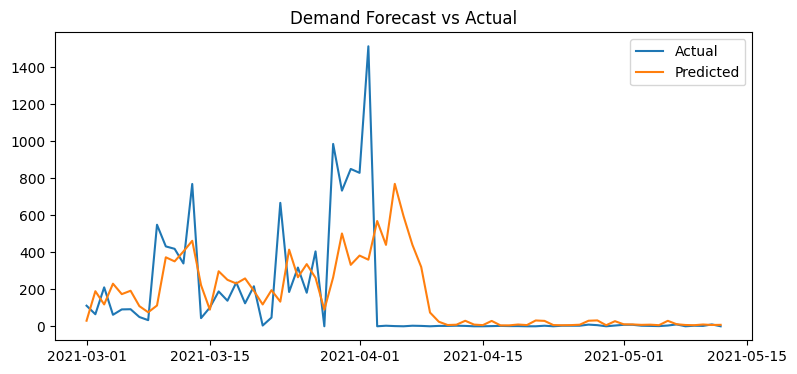

In [228]:
plt.figure(figsize=(9,4))
plt.plot(test['appointment_date_continuous'], y_test.values, label='Actual')
plt.plot(test['appointment_date_continuous'], pred, label='Predicted')
plt.title("Demand Forecast vs Actual")
plt.legend()
plt.show()

In [229]:
from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test, pred))
print("R2 :", r2_score(y_test, pred))

MAE: 141.53301369863016
R2 : 0.155685257325191


In [234]:
daily['appointment_date_continuous']

7     2020-01-08
8     2020-01-09
9     2020-01-10
10    2020-01-11
11    2020-01-12
         ...    
493   2021-05-08
494   2021-05-09
495   2021-05-10
496   2021-05-11
497   2021-05-12
Name: appointment_date_continuous, Length: 491, dtype: datetime64[ns]